# Enhanced Pancreas Cell Analysis with scGPT

This notebook provides a comprehensive analysis of pancreatic cell data using scGPT embeddings.
We'll perform:
- Data loading and validation
- Embedding analysis
- Dimensionality reduction
- Batch effect analysis
- Machine learning model comparison

## 1. Setup and Imports

In [1]:
# Import required libraries
from pathlib import Path
import warnings
import scanpy as sc
import scib 
import numpy as np
import pandas as pd
import sys 
import scgpt as scg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import umap

# Set plotting style
plt.style.context('default')
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scgpt\model\model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scgpt\model\multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\umap\__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


In [3]:
def setup_directories():
    """Set up necessary directories and paths"""
    repo_dir = Path.cwd().parent.absolute()
    data_dir = repo_dir / "data"
    save_dir = repo_dir / "save"
    
    # Create directories if they don't exist
    data_dir.mkdir(parents=True, exist_ok=True)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    return repo_dir, data_dir, save_dir

# Set up configuration
config = {
    "file_path": "  h5ad",
    "n_top_genes": 1800,
    "gene_col": "gene_name",
    "cell_type_key": "celltype",
    "batch_key": "donor_id",
    "normalize_total": 1e4,
    "binning": 10,
    "use_hvg": True
}

# Set up directories
repo_dir, data_dir, save_dir = setup_directories()
print(f"Repository directory: {repo_dir}")
print(f"Data directory: {data_dir}")
print(f"Save directory: {save_dir}")

Repository directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT
Data directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\data
Save directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\save


## 2. Data Loading and Initial Processing

In [21]:
# Define file paths and parameters
hvg_file = Path("C:/Users/annel/OneDrive/Documenten/Machine Learning/scGPT/save/adata_hvg.h5ad")
embed_file = Path(r"C:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\Stromal_cells_all_non-immune_cells_embedded.h5ad")
# Load HVG data
if hvg_file.exists():
    print(f"Loading existing HVG AnnData file from {hvg_file}")
    adata = sc.read_h5ad(hvg_file)
    print(f"Loaded AnnData with shape: {adata.shape}")
else:
    print("No existing HVG AnnData file found")

# Set up parameters
gene_col = "gene_name"
cell_type_key = "celltype"
batch_key = "donor_id"
N_HVG = 1800

Loading existing HVG AnnData file from C:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\save\adata_hvg.h5ad
Loaded AnnData with shape: (16382, 1800)


## 3. Load and Analyze Embeddings

In [5]:
# Load embedded data
adata_embed = sc.read_h5ad(embed_file)
print("\nEmbedded data information:")
print(adata_embed)

# Create dataframe from embeddings
embeddings_df = pd.DataFrame(adata_embed.obsm["X_scGPT"])
print("\nFirst few rows of scGPT embeddings:")
print(embeddings_df.head())

# Basic statistics
print("\nEmbedding Statistics:")
print(embeddings_df.describe())


Embedded data information:
AnnData object with n_obs × n_vars = 61525 × 24256
    obs: 'mapped_reference_annotation', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_derivation_process', 'tissue_type', 'suspension_derivation_process', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nucleosome_signal', 'TSS.enrichment', 'onset', 'duration', 'lateralization', 'histological_assessment', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'vf_vst_counts.G120_N.1_mean', 'vf_vst_counts.G120_N.1_va

In [6]:
repo_dir = Path.cwd().parent.absolute()
sys.path.append(str(repo_dir))

from src.utils import setup_data_dir
setup_data_dir()
data_dir = repo_dir / "data"

# Set up of the model directory 
model_dir = repo_dir / "scGPT_data" / "scGPT_CP"

print(f"Repository directory: {repo_dir}")
print(f"Model directory: {model_dir}")

from my_src.my_utils import check_annotation_keys

Repository directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT
Model directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\scGPT_data\scGPT_CP


In [23]:
keys = check_annotation_keys(adata_embed)
print (keys)
cell_type_key = keys["cell_type_keys"][0]
print (cell_type_key)


Checking cell type annotations in .obs:

✓ Found 'cell_type' with 15 unique values
Examples:
  1. L2/3 intratelencephalic projecting glutamatergic neuron
  2. endothelial cell
  3. glutamatergic neuron
  4. astrocyte
  5. pvalb GABAergic cortical interneuron
Top counts:
  oligodendrocyte: 17108 cells
  glutamatergic neuron: 8984 cells
  L2/3 intratelencephalic projecting glutamatergic neuron: 8686 cells
  astrocyte: 5347 cells
  microglial cell: 4674 cells

Checking gene annotations in .var:

✓ Found 'feature_name' with 24256 unique values
Examples:
  1. MIR1302-2HG
  2. FAM138A
  3. OR4F5
  4. OR4F29
  5. OR4F16

Checking highly variable gene annotations in .var:

⚠️ No HVG annotations found in .var columns

Checking additional metadata:
Available .uns keys: ['citation', 'default_embedding', 'schema_reference', 'schema_version', 'title', 'neighbors', 'umap', 'is_ref_colors', 'cell_type_colors']
Available .layers: []
{'cell_type_keys': ['cell_type'], 'gene_keys': ['feature_name'], 'hv

## 4. Create Train/Test Split

In [14]:
# Create reference and query datasets
mask = np.random.rand(len(adata_embed)) < 0.8

# Create a column indicating whether each cell is from reference or query set
adata_embed.obs["is_ref"] = ["Reference" if m else "Query" for m in mask]
adata_embed.obs["is_ref"] = adata_embed.obs["is_ref"].astype("category")

# Split the data
adata_ref = adata_embed[mask].copy()
adata_query = adata_embed[~mask].copy()

print(f"Reference dataset shape: {adata_ref.shape}")
print(f"Query dataset shape: {adata_query.shape}")

Reference dataset shape: (49167, 24256)
Query dataset shape: (12358, 24256)


## 5. Visualization with UMAP

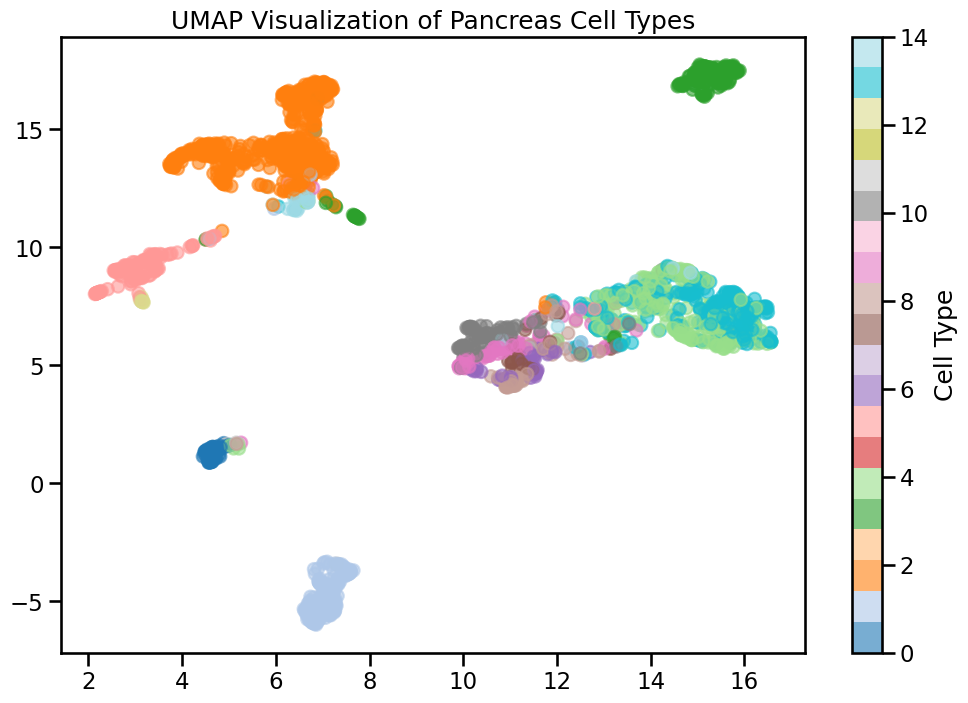

In [15]:
# Prepare UMAP visualization
reducer = umap.UMAP(random_state=42)
random_indices = np.random.choice(adata_embed.shape[0], size=2000, replace=False)
umap_embeddings = reducer.fit_transform(adata_embed.obsm["X_scGPT"][random_indices])

# Create UMAP plot using the previously determined cell_type_key
plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],
                     c=adata_embed.obs[cell_type_key].cat.codes[random_indices],
                     cmap='tab20', alpha=0.6)
plt.title("UMAP Visualization of Pancreas Cell Types")
plt.colorbar(scatter, label="Cell Type")
plt.show()

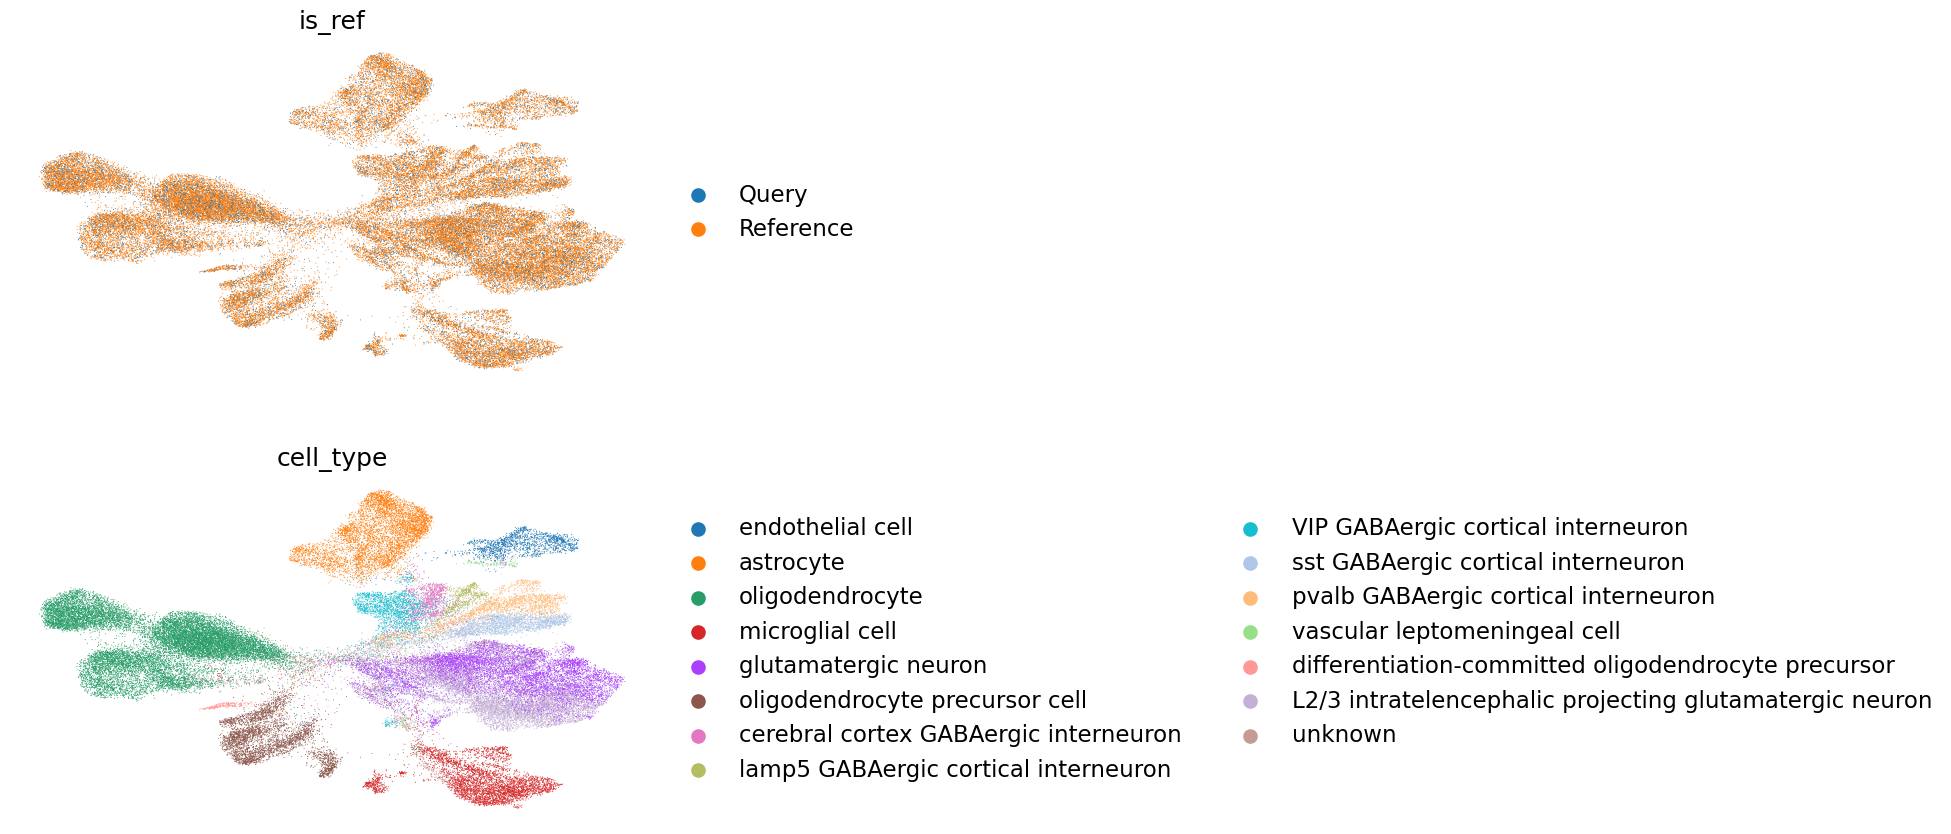

In [16]:
sc.pp.neighbors(adata_embed, use_rep="X_scGPT")
sc.tl.umap(adata_embed)
sc.pl.umap(
    adata_embed, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
)

## 6. Batch Effect Analysis

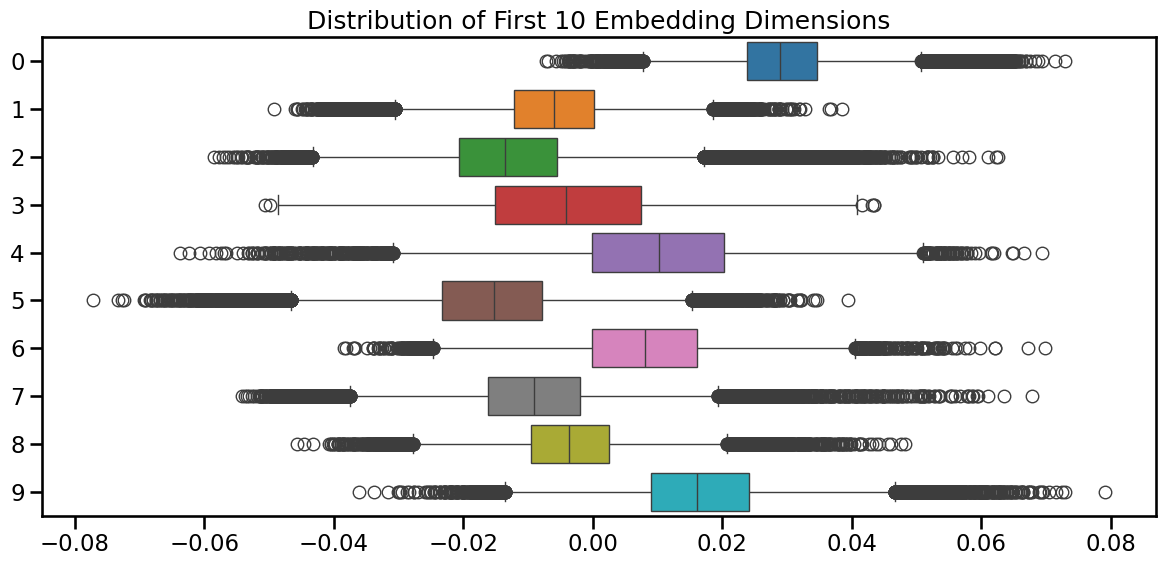


Batch distribution across cell types:
cell_type  endothelial cell  astrocyte  oligodendrocyte  microglial cell  \
donor_id                                                                   
G120                    148        405             1658             2659   
G129                    299        718             2625              283   
G133                    481       3047             3617             1322   
G150                     43         56             1080                3   
G159                    365        431              915               82   
G171                     40         70               86                2   
G187                     27        146             2397               30   
G210                    217        474             4730              293   

cell_type  glutamatergic neuron  oligodendrocyte precursor cell  \
donor_id                                                          
G120                       1081                            1234   

In [24]:
# Visualize batch effects
plt.figure(figsize=(12, 6))
sns.boxplot(data=embeddings_df.iloc[:, :10], orient="h")
plt.title("Distribution of First 10 Embedding Dimensions")
plt.tight_layout()
plt.show()

# Create batch effect summary
batch_summary = pd.crosstab(adata_embed.obs[batch_key], 
                           adata_embed.obs[cell_type_key])
print("\nBatch distribution across cell types:")
print(batch_summary)

In [20]:
print (batch_key)

tech


## 7. Machine Learning Model Comparison

In [25]:
# Prepare data for modeling
X = pd.DataFrame(adata_embed.obsm["X_scGPT"])
y = adata_embed.obs[cell_type_key]

# Create train/test split considering batch effects
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=adata_embed.obs[batch_key]))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Train and evaluate models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=10),
    "Random Forest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, class_weight="balanced")
}

results = []
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        'model': name,
        'macro_avg_f1': report['macro avg']['f1-score'],
        'weighted_avg_f1': report['weighted avg']['f1-score']
    })
    
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# Show final results
results_df = pd.DataFrame(results)
print("\nFinal Model Comparison:")
print(results_df)


Training KNN...

KNN Classification Report:
                                                         precision    recall  f1-score   support

L2/3 intratelencephalic projecting glutamatergic neuron       0.75      0.78      0.77      2679
                     VIP GABAergic cortical interneuron       0.85      0.91      0.88       900
                                              astrocyte       0.97      0.96      0.97      1193
                  cerebral cortex GABAergic interneuron       0.89      0.71      0.79       510
    differentiation-committed oligodendrocyte precursor       0.87      0.86      0.87       152
                                       endothelial cell       0.95      0.88      0.91       487
                                   glutamatergic neuron       0.76      0.82      0.79      3324
                   lamp5 GABAergic cortical interneuron       0.92      0.74      0.82       406
                                        microglial cell       0.95      0.98     

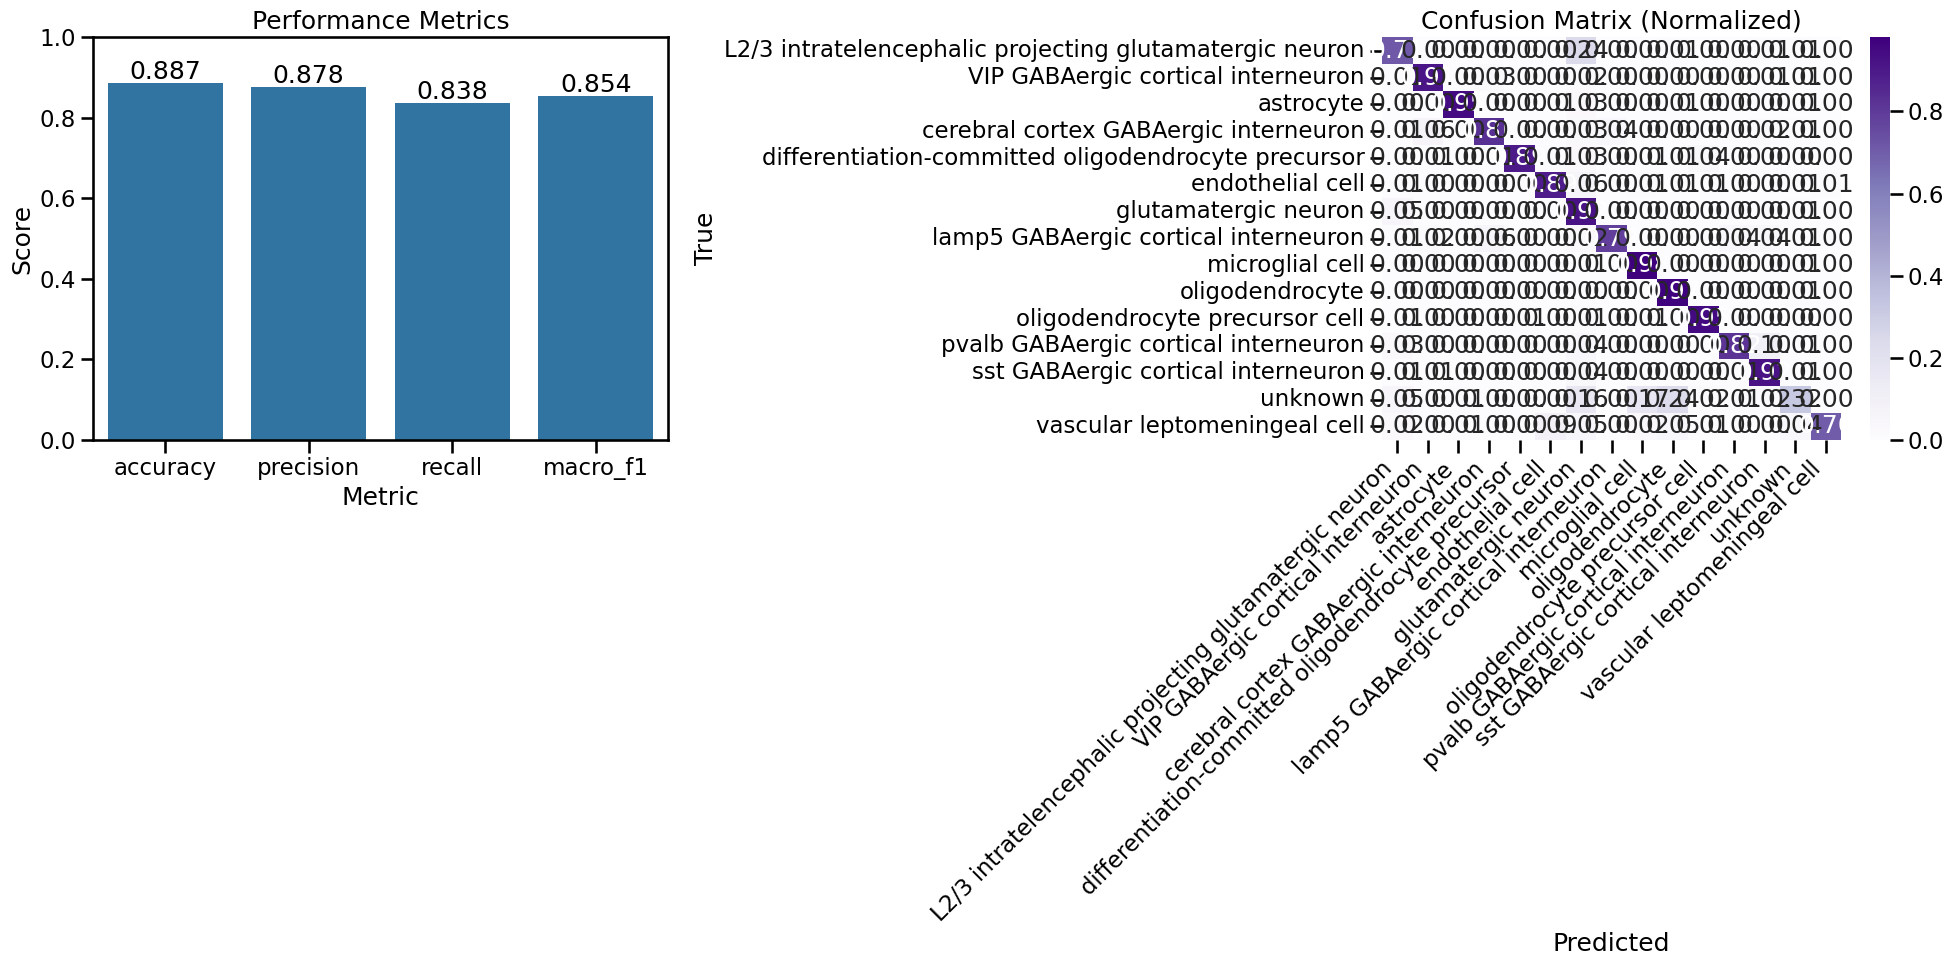


Detailed Performance Metrics:
accuracy: 0.887
precision: 0.878
recall: 0.838
macro_f1: 0.854


In [26]:
# Calculate performance metrics for the best model (LightGBM)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Use the predictions from LightGBM (best performing model)
best_model = models["LightGBM"] # but can use another one 
y_pred = best_model.predict(X_test)
gt = y_test  # ground truth
preds = y_pred

res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

fig = plt.figure(figsize=(20, 10))

# Left subplot for metrics
ax1 = plt.subplot(121)
metrics_df = pd.DataFrame(list(res_dict.items()), columns=['Metric', 'Score'])
sns.barplot(x='Metric', y='Score', data=metrics_df, ax=ax1)
ax1.set_title('Performance Metrics')
ax1.set_ylim(0, 1)  # Set y-axis from 0 to 1
for i, v in enumerate(metrics_df['Score']):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')  # Add value labels

# Right subplot for confusion matrix
ax2 = plt.subplot(122)
cell_type_list = np.unique(gt)
matrix = confusion_matrix(gt, preds, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

# Create confusion matrix heatmap
df = pd.DataFrame(matrix, 
                 index=cell_type_list[:matrix.shape[0]], 
                 columns=cell_type_list[:matrix.shape[1]])
sns.heatmap(df, 
            cmap='Purples',
            annot=True,
            fmt=".2f",
            cbar=True,
            ax=ax2)

ax2.set_title('Confusion Matrix (Normalized)')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

# Rotate x-axis labels for better readability
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax2.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Performance Metrics:")
for metric, value in res_dict.items():
    print(f"{metric}: {value:.3f}")

## 8. Save Results and Embeddings

In [27]:
# Save the processed data
adata_embed.write_h5ad("pancreas_analysis_results.h5ad")
results_df.to_csv("model_comparison_results.csv")

print("Analysis complete! Results have been saved.")

Analysis complete! Results have been saved.
